<a href="https://colab.research.google.com/github/gideononyewuenyi/Time-Series-Forecasting/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting

##### **Time Series** is a series of observations taken at specified time intervals usually equal intervals. Analysis of the series helps us to predict future values based on previous observed values. In Time series, we have only 2 variables, time & the variable we want to forecast.


In [39]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [40]:
#@title
def plot_series(time, series, format="-", start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")
  if label:
      plt.legend(fontsize=14)
  plt.grid(True)

# Trend and Seasonality

In [41]:
#@title
def trend(time, slope=0):
  return slope * time

### Let's create a time series that just trends upward

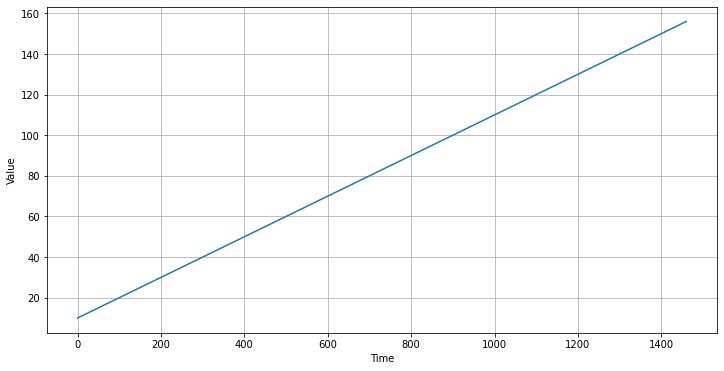

In [42]:
#@title
time = np.arange (4 * 365 + 1)
baseline=10
series = baseline + trend (time, 0.1)

plt.figure(figsize=(12,6))
plot_series(time, series)
plt.show()

In [43]:
#@title
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [44]:
#@title
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

In [45]:
#@title


### Let's generate seasonal pattern

In [46]:
#@title
def seasonal_pattern(season_time):
  """just arbitrary, can change if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  """repeat the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

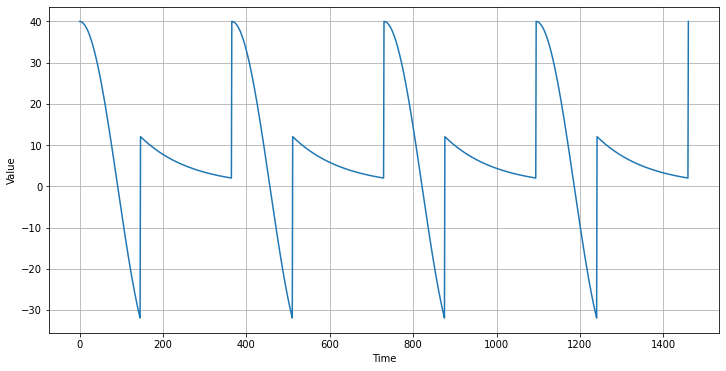

In [47]:
#@title
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(12,6))
plot_series (time, series)
plt.show()

In [48]:
#@title


#### Now let's create time series with both trend asnd seasonality

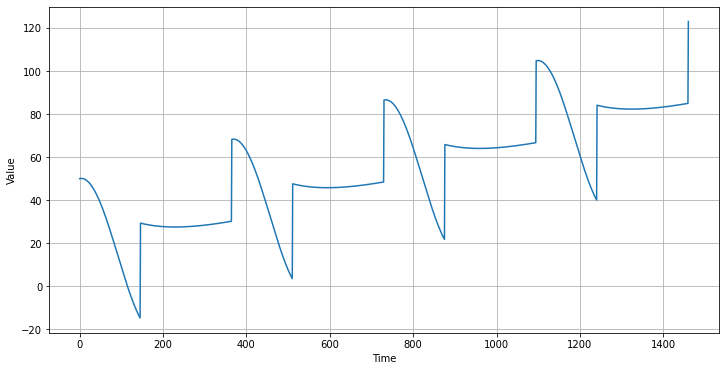

In [49]:
#@title
slope=0.05
series = baseline + trend (time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(12,6))
plot_series(time, series)
plt.show()

# Noise

In [50]:
#@title
def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

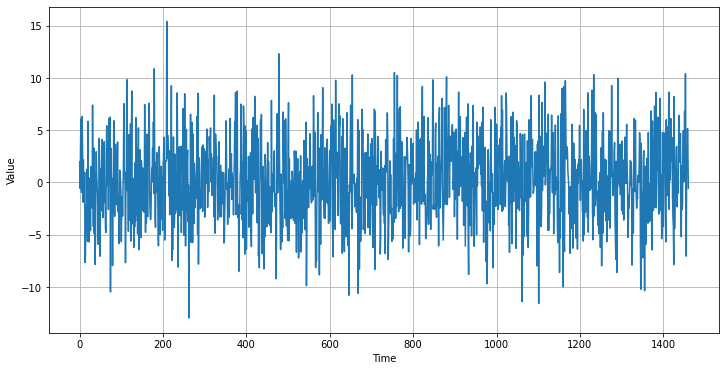

In [51]:
#@title
noise_level = 4
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(12,6))
plot_series(time,noise)
plt.show()

### now let's add white noise to the time series

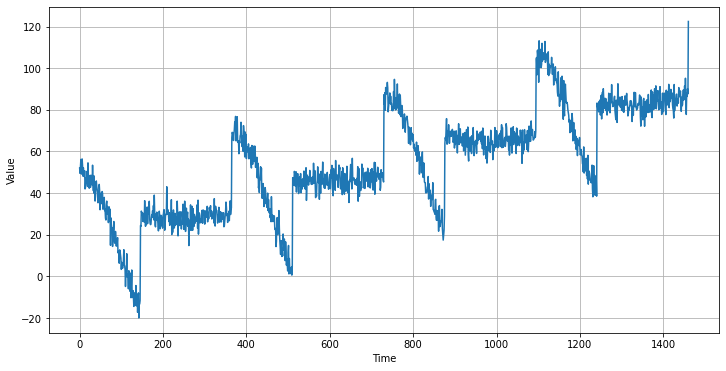

In [52]:
#@title
series += noise

plt.figure(figsize=(12,6))
plot_series(time, series)
plt.show()

In [53]:
#@title


# Naive Forecast

#### Trying to say tomorrow will be the same as today

#### split the datasets

In [54]:
#@title
split_time = 1000
time_train = time [:split_time]
x_train = series [:split_time]
time_valid = time [split_time:]
x_valid = series [split_time:]

In [55]:
#@title
naive_forecast = series[split_time - 1:-1]

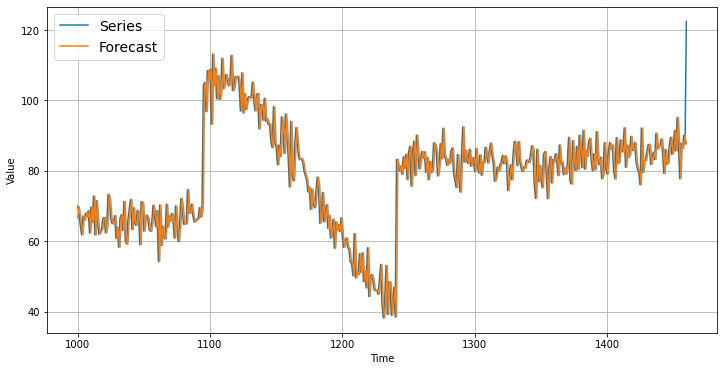

In [56]:
#@title
plt.figure(figsize=(12, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

#### Let's zoom in

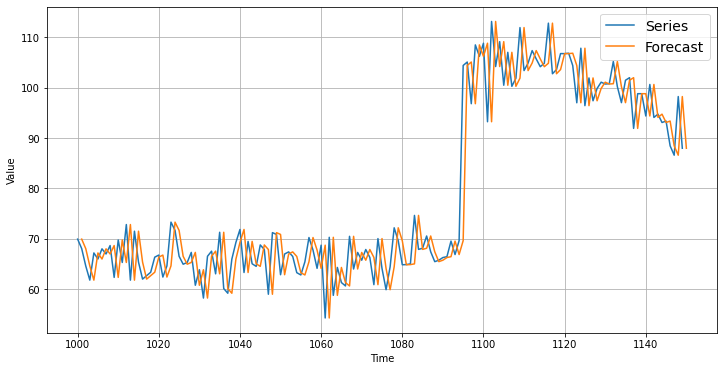

In [57]:
#@title
plt.figure(figsize=(12,6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [58]:
#@title


#### computing the mean squared error between forecast and prediction in the validation 

In [59]:
#@title
errors = naive_forecast - x_valid
square_errors = np.square(errors)
mse = square_errors.mean()
mse

43.18498948576009

In [60]:
#@title
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

4.805340169814075

In [61]:
#@title
errors = naive_forecast - x_valid
abs_errors = np.abs(errors / x_valid)
mape = abs_errors.mean()
mape

0.06330335426716306

In [62]:
#@title
mse = np.square(errors).mean()
mse

43.18498948576009

In [63]:
#@title
mae = np.abs(errors).mean()
mae

4.805340169814075

In [64]:
#@title
mape = np.abs(errors / x_valid).mean()
mape

0.06330335426716306

#### if large errors are potentially going to cost you much more than smaller errors, you'd prefer MSE

#### if your gain or loss is just proportional to the size of the error, MAE may be better

#### MAPE - mean ratio between the absolute error and the absolute value, which gives an idea of the size of the error compared to the values.

In [65]:
#@title
import keras
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

4.805340169814074

In [66]:
#@title


# Moving Average

#### The mean of past N values
removes a lot of noise but does not anticipate trends and seasonality, might be worse than naive forecasting in this scenario and we can fix this by removing trends and seasonality using differencing - instead of studying time series itself, we study the difference between the value at time T and the value some time earlier at time T - x(some time earlier) we get differenced time series which has no trend and seasonality. we can then use moving average to forecast, remember its just forecast for the differenced time series not the original time series. To get the final forecast of the time series we need to add back the value at time T - x 

Moving average of differenced series + series (t-365) slightly better than naive forcasting

Moving average removed a  lot of noise but final forecast still noisy - came back from the past value we added back to our forecasts - so we can improve this forecast by also removing the past noise using a moving average - will be much better than all others

Keep this in mind before you rush to deep learning, simple approaches may work just fine

nb: from t-365-5 to t+365+5
Moving average using centerd windows are more accurate than using trailing windows but we cant use centered windows to smooth present values since we do not know future values. to smooth past values we can afford to use centered windows

#### Trying to say tomorrow will be close to the average of the values over the past few days (the last 7 days for example)

In [67]:
#@title
def moving_average_forecast(series, window_size):
  """Forecast the mean of the last few values.
  if window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [68]:
#@title
def moving_average_forecast(series, window_size):
  """Forecast the mean of the last few values.
  If windows_size=1, then this is equivalent to naive forecast
  This implementation is much faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size -1:-1] / window_size

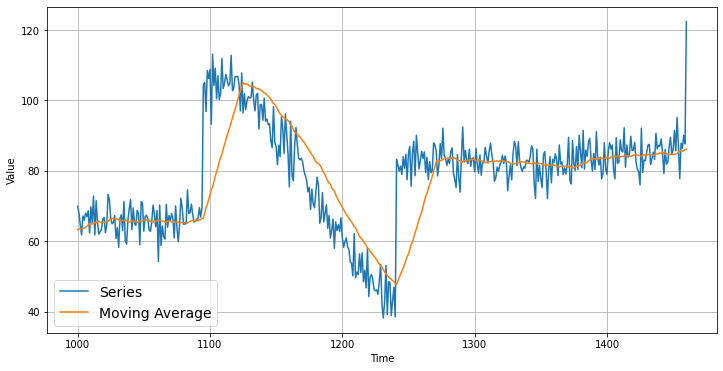

In [69]:
#@title
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(12,6))
plot_series (time_valid, x_valid, label="Series")
plot_series (time_valid, moving_avg, label="Moving Average")

In [70]:
#@title
import keras
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

6.589230262250396

#### not better than naive forecast, main reason is delay time for the moving average to find it's value. when the actual values are stable, the forecast look good but when there is a lot of change, we dont get good result

moving average does not anticipate trends and seasonality

#### we can remove trends and seasonality using differencing - subtract the value of time series of 365 days ago to the time series of today = t - 365 - this is called differencing

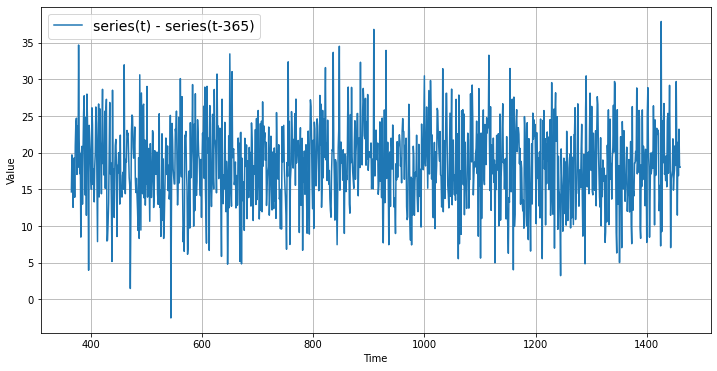

In [71]:
#@title
dif_series = (series[365:] - series[:-365])
dif_time = time[365:]

plt.figure(figsize=(12,6))
plot_series(dif_time, dif_series, label="series(t) - series(t-365)")
plt.show()

#### now we can use the moving average with differencing

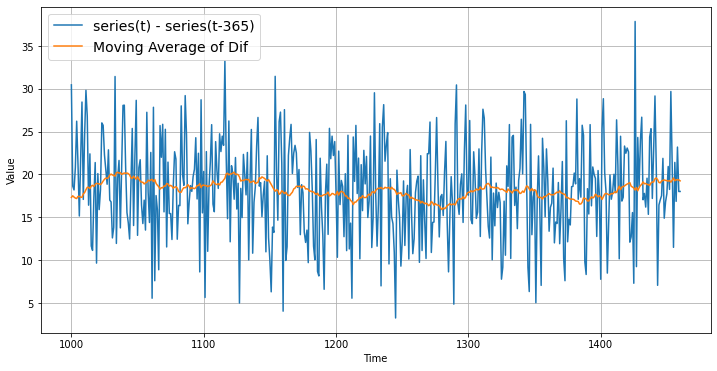

In [72]:
#@title
dif_moving_average = moving_average_forecast (dif_series, 40)[split_time - 365 - 40:]

plt.figure(figsize=(12,6))
plot_series(time_valid, dif_series[split_time - 365:], label="series(t) - series(t-365)")
plot_series(time_valid, dif_moving_average, label="Moving Average of Dif")

#### here, the forecast was able to capture the mean of the time series

In [73]:
#@title


#### now how do you use this forecast to make forecast on the original time series - we will add the new forecast to the value of the forecast one year ago - we add back what we subtracted earlier

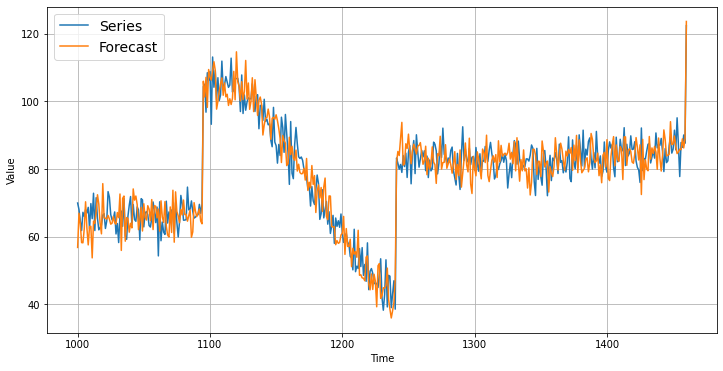

In [74]:
#@title
dif_moving_average_plus_past_value = series[split_time -365:-365] + dif_moving_average

plt.figure(figsize=(12,6))
plot_series (time_valid, x_valid, label="Series")
plot_series (time_valid, dif_moving_average_plus_past_value, label="Forecast")


#### we have this output which looks close to the original data

#### lets find out if it is better than naive forecast

In [75]:
#@title
keras.metrics.mean_absolute_error(x_valid, dif_moving_average_plus_past_value).numpy()

4.7019015108991455

#### just a slight change after all the effort, not so encouraging

In [76]:
#@title


#### we can see that the forecast is a bit noisy, we are actually a bit far from the actual data due to noise

how to remove noise - it comes from the value of the time series one year ago, so maybe we want to do some moving average from one year ago, - one year ago we can compute the moving average over one year ago minus 15 days up to one year ago + 15 days

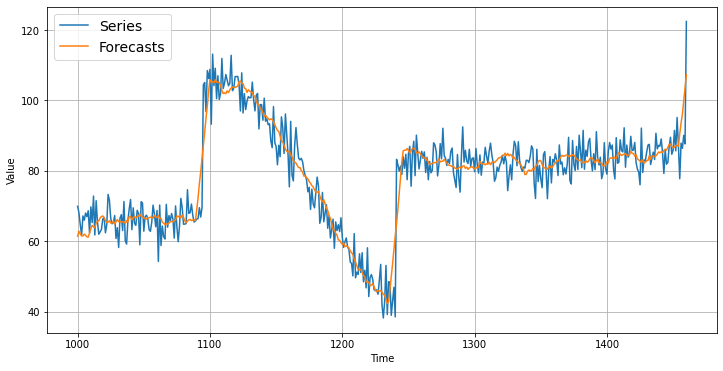

In [77]:
#@title
dif_moving_average_with_smooth_past = moving_average_forecast (series[split_time - 370:-359], 11) + dif_moving_average

plt.figure(figsize=(12, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, dif_moving_average_with_smooth_past, label="Forecasts")
plt.show()

#### better with less noise, we can expect something better now

In [78]:
#@title
keras.metrics.mean_absolute_error(x_valid, dif_moving_average_with_smooth_past).numpy()

3.7875805221003684

### MAE of 3.79 is better

In [79]:
#@title


## Machine Learning

simplest approach is to build a model that will learn to forecast the next time step - given a time window, we want the model to forecast the next time step. we need to choose window size (for e.g 31 days)
we must prepare a dataset of all possible time windows of that size

In [94]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [96]:
 dataset = tf.data.Dataset.range(10)
 dataset = dataset.window(5, shift=1)
 for w_d in dataset:
   for val in w_d:
     print(val.numpy(), end="")
   print()  

01234
12345
23456
34567
45678
56789
6789
789
89
9


In [100]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for w_d in dataset:
   for val in w_d:
     print(val.numpy(), end="")
   print()  

01234
12345
23456
34567
45678
56789


In [101]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [103]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


## Import some relevant packages

In [85]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from IPython.display import display, HTML, display_html
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Read in my data

In this notebook, we will be using a dataset of air quality obtained from the Purpleair sensor in Port Harcourt, Nigeria

In [86]:
#@title
url = "https://raw.githubusercontent.com/gideononyewuenyi/Exploratory-analysis/main/Lekki%20Phase%201%20(outside)%20(6.451397%203.471201)%20Primary%2030_minute_average%2012_17_2019%206_6_2021.csv"
df = pd.read_csv (url)
#url = "https://raw.githubusercontent.com/gideononyewuenyi/Time-Series-Forecasting/main/Port%20Harcourt%2C%20Nigeria%20(outside)%20(4.80678%207.002953)%20Primary%20Real%20Time%2007_27_2021%2008_03_2021.csv"
#df = pd.read_csv (url)

## Take a look at my data
- How many rows and columns are in the dataset?
- What data types are the columns?
- Is the data complete? Are there nulls? 


In [87]:
#@title
# look at data
display(df.head())

# look a shape of data
display(df.shape)

# look at data types. Ideally look at all rows. Only look at first five here for minimal output.
display(df.iloc[:5,:5].dtypes)

# see if any columns have nulls. Ideally look at all rows. Only look at first five here for minimal output.
display(df.iloc[:5,:5].isnull().any())

# display descriptive statistics
display(df.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

,created_at,PM1.0_CF1_ug/m3,PM2.5_CF1_ug/m3,PM10.0_CF1_ug/m3,UptimeMinutes,RSSI_dbm,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3,Unnamed: 9
0,2019-12-17 20:00:00 UTC,1.99,3.05,3.27,3.25,-53.75,72.50,16.50,3.05,NaN
1,2019-12-17 20:30:00 UTC,1.89,2.80,3.09,11.19,-53.69,73.88,15.12,2.80,NaN
2,2019-12-17 21:00:00 UTC,34.62,93.43,141.47,38.00,-53.87,74.07,15.40,63.67,NaN
3,2019-12-17 21:30:00 UTC,0.89,2.59,3.58,68.00,-55.47,76.53,15.00,2.59,NaN
4,2019-12-17 22:00:00 UTC,0.00,0.00,0.01,98.00,-54.60,77.00,14.87,0.00,NaN


(37595, 10)

created_at           object
PM1.0_CF1_ug/m3     float64
PM2.5_CF1_ug/m3     float64
PM10.0_CF1_ug/m3    float64
UptimeMinutes       float64
dtype: object

created_at          False
PM1.0_CF1_ug/m3     False
PM2.5_CF1_ug/m3     False
PM10.0_CF1_ug/m3    False
UptimeMinutes       False
dtype: bool

,PM1.0_CF1_ug/m3,PM2.5_CF1_ug/m3,PM10.0_CF1_ug/m3,UptimeMinutes,RSSI_dbm,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3,Unnamed: 9
count,37538.000000,37538.000000,37538.000000,37538.000000,37538.000000,37538.000000,37538.000000,37538.000000,0.0
mean,6.007100,8.584424,9.092260,22233.899164,-66.844293,78.717398,31.854816,7.991469,NaN
std,10.415071,16.605593,18.286916,18422.876237,8.783105,6.350175,12.522367,12.175910,NaN
min,0.000000,0.000000,0.000000,2.000000,-87.000000,52.200000,10.000000,0.000000,NaN
25%,1.470000,2.120000,2.280000,6348.000000,-74.200000,73.930000,22.000000,2.120000,NaN
50%,3.470000,4.750000,5.030000,18293.000000,-69.930000,79.000000,30.000000,4.750000,NaN
75%,6.990000,9.580000,10.037500,34524.000000,-58.330000,83.000000,40.530000,9.570000,NaN
85%,9.860000,13.810000,14.480000,44419.000000,-57.400000,85.800000,46.670000,13.780000,NaN
95%,19.864500,28.023000,29.471500,58248.000000,-55.800000,89.000000,54.279000,27.500000,NaN
99%,41.780000,62.187100,65.110000,67808.750000,-54.600000,94.695200,62.244100,45.968900,NaN


## Processing my data

In [88]:
#@title
# Rename columns
df = df.rename(columns = {'created_at': 'dt', 'PM2.5_CF1_ug/m3': 'pm'})

warnings.filterwarnings("ignore")

# Change index to datetime
df['dt'].index = pd.to_datetime(df.index)

# Sort the values
df = df.sort_index(ascending = True)

# Fill values with forward fill
df = df.fillna(method='ffill')

# Show the end of the data
display(df.tail())

,dt,PM1.0_CF1_ug/m3,pm,PM10.0_CF1_ug/m3,UptimeMinutes,RSSI_dbm,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3,Unnamed: 9
37590,2021-06-06 06:00:00 UTC,40.47,56.64,59.53,798.0,-77.33,86.00,64.00,44.06,NaN
37591,2021-06-06 06:30:00 UTC,40.47,56.64,59.53,798.0,-77.33,86.00,64.00,44.06,NaN
37592,2021-06-06 07:00:00 UTC,26.22,37.35,39.07,962.0,-82.31,88.38,62.62,34.06,NaN
37593,2021-06-06 07:30:00 UTC,23.22,33.16,34.51,990.0,-75.20,89.73,57.33,31.54,NaN
37594,2021-06-06 08:00:00 UTC,23.23,32.86,33.53,1008.0,-75.67,91.00,55.33,31.37,NaN


## Plot my data
* Is there an overall increasing trend? (movement of a series to relatively higher or lower values over a long period of time)
- Are there some differences in the variance over time? (increased amplitudes during the course of the time period observed)
- There may be some seasonality (i.e., cycles) in the data. (cycles that repeat regularly over time)

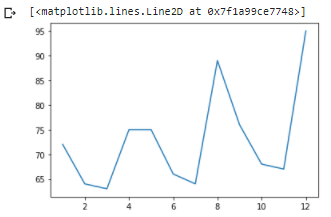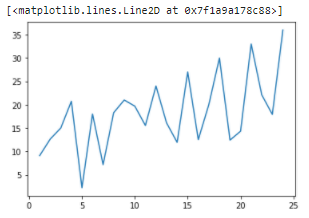

Text(0, 0.5, 'PM2.5')

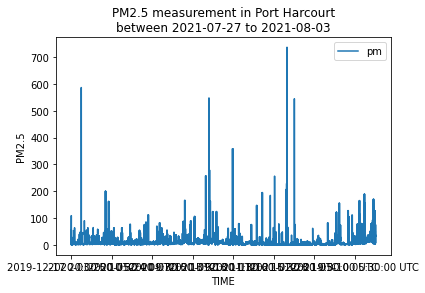

In [89]:
#@title
df.plot(x="dt", y= 'pm')
plt.title("PM2.5 measurement in Port Harcourt\nbetween 2021-07-27 to 2021-08-03", size=12)
plt.xlabel('TIME', size=10)
plt.ylabel('PM2.5', size=10)

## Look at stationarity
Before applying any statistical model on a Time Series, the series has to be staionary, which means that, over different time periods,
*  It should have constant mean.
*  It should have constant variance or standard deviation.
*  Auto-covariance (used to estimate. the dominant periods in the time series) should not depend on time.

If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.

##### Dickey-Fuller test is statistical tests for checking stationarity, while Rolling Statistics is more of a visual technique. In rolling statistics we plot the mean and standard deviation of the time series and see if it varies with time. Dickey-Fuller test comprise of a Test Statistic and some Critical Values for different confidence levels(1%, 5%, 10%). We visualize the results and if the ‘Test Statistic’ is less than the ‘Critical Value’, we can infer that the series is stationary.
**ADF statistic > critical value:** Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. **ADF statistic < critical value:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.